In [1]:
import os
import re
import sys
import numpy as np
from Bio import SeqIO
# from Bio.Seq import Seq
# from Bio.SeqRecord import SeqRecord
#pairwise also 
# from Bio import pairwise2
from multiprocessing import Pool
import time
import hashlib

In [2]:
# def generate_minhash_signature(k, n, num_hashes):
#     """Generate MinHash signature for the files"""
#     signature = []
#     for i in range(k):
#         with open(f'file{i}.txt', 'r') as file:
#             lines = file.readlines()
#             data = [int(line.strip()) for line in lines]

#         minhash = [float('inf')] * num_hashes  # Initialize with infinity

#         # Generate hash values using different hash functions
#         for num in data:
#             for j in range(num_hashes):
#                 hash_val = int(hashlib.sha256(str(num).encode() + str(j).encode()).hexdigest(), 16)
#                 minhash[j] = min(minhash[j], hash_val)

#         signature.append(minhash)

#     return signature


#i want to do this for fasta files sequences 
data = {}

In [3]:
def get_fasta_files(directory):
    files = os.listdir(directory)
    fasta_files = []
    for file in files:
        if re.search(r"\.fasta$", file):
            fasta_files.append(file)
    return fasta_files

In [4]:
fasta_files = get_fasta_files("chi")

In [5]:
for file in fasta_files:
    with open("chi/" + file, "r") as f:
        data[file] = {}

In [6]:
for file in fasta_files:
    for record in SeqIO.parse("chi/" + file, "fasta"):
        data[file][record.id] = str(record.seq)

In [7]:
sequences = []
labels = []
for file in data:
    for header in data[file]:
        sequences.append(data[file][header])
        labels.append(header)

In [8]:
#Now I want to encode the sequences using integers 
#Find the unique characters in the sequences
unique_chars = set()
for seq in sequences:
    for char in seq:
        unique_chars.add(char)

print(unique_chars)

{'C', 'T', 'A', 'G'}


In [9]:
dict_encode = {}
dict_encode["A"] = 0
dict_encode["C"] = 1
dict_encode["G"] = 2
dict_encode["T"] = 3

In [10]:
#Now I want to encode the sequences
encoded_sequences = []
for seq in sequences:
    encoded_seq = ""
    for char in seq:
        encoded_seq += str(dict_encode[char])
    encoded_sequences.append(encoded_seq)

In [11]:
#Now in the "text_files_draft" I want to create text files with the encoded sequences
#filei should contain the encoded sequence of sequences[i] in a single line
from tqdm import tqdm
for i in tqdm(range(len(encoded_sequences))):
    with open("text_files_draft/file" + str(i) + ".txt", "w") as f:
        # for char in encoded_sequences[i]:
        #     f.write(char + "\n")
        # Put each k-mer in a new line
        k = 10 # k-mer length
        for j in range(0, len(encoded_sequences[i]) - k + 1, 1):
            f.write(encoded_sequences[i][j:j+k] + "\n")

100%|██████████| 600/600 [00:01<00:00, 598.35it/s]


In [12]:
def generate_minhash_signature(k, n, num_hashes):
    """Generate MinHash signature for the files"""
    signature = []
    for i in range(k):
        with open(f'text_files_draft/file{i}.txt', 'r') as file:
            lines = file.readlines()
            data = [int(line.strip()) for line in lines]

        minhash = [float('inf')] * num_hashes  # Initialize with infinity

        # Generate hash values using different hash functions
        for num in data:
            for j in range(num_hashes):
                hash_val = int(hashlib.sha256(str(num).encode() + str(j).encode()).hexdigest(), 16)
                minhash[j] = min(minhash[j], hash_val)

        signature.append(minhash)

    return signature

In [13]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    similarity = intersection / union
    
    return similarity

In [14]:
num_hashes = 32
minhash_signature = generate_minhash_signature(600, 400, num_hashes)
print(len(minhash_signature))

600


In [15]:
sys.set_int_max_str_digits(1000000)

In [16]:
results_adj = [[0 for i in range(600)] for j in range(600)]


In [17]:
start = time.time()

for i in range(600):
    data_1 = minhash_signature[i]
    for j in range(i,600):
        data_2 = minhash_signature[j]
        sim = jaccard_similarity(data_1,data_2)
        results_adj[i][j] = sim
        results_adj[j][i] = sim
        
end = time.time()
print("{} minutes".format(round((end - start)/60,2)))

0.02 minutes


In [18]:
results_adj

[[1.0,
  0.06666666666666667,
  0.04918032786885246,
  0.03225806451612903,
  0.6410256410256411,
  0.03225806451612903,
  0.10344827586206896,
  0.3333333333333333,
  0.06896551724137931,
  0.016129032258064516,
  0.03225806451612903,
  0.04918032786885246,
  0.14285714285714285,
  0.5238095238095238,
  0.03225806451612903,
  0.016129032258064516,
  0.08620689655172414,
  0.01639344262295082,
  0.0,
  0.30612244897959184,
  0.08620689655172414,
  0.01639344262295082,
  0.05084745762711865,
  0.04918032786885246,
  0.10344827586206896,
  0.8285714285714286,
  0.23076923076923078,
  0.18867924528301888,
  0.05,
  0.03225806451612903,
  0.6,
  0.06666666666666667,
  0.0,
  0.06666666666666667,
  0.04918032786885246,
  0.0847457627118644,
  0.0847457627118644,
  0.12280701754385964,
  0.14285714285714285,
  0.03278688524590164,
  0.06779661016949153,
  0.03333333333333333,
  0.03278688524590164,
  0.08771929824561403,
  0.015873015873015872,
  0.0,
  0.05,
  0.08620689655172414,
  0.16363

In [19]:
adj_new = 1-np.array(results_adj)

In [20]:
adj_new

array([[0.        , 0.93333333, 0.95081967, ..., 0.98387097, 1.        ,
        0.98360656],
       [0.93333333, 0.        , 0.81481481, ..., 1.        , 1.        ,
        1.        ],
       [0.95081967, 0.81481481, 0.        , ..., 1.        , 1.        ,
        0.98360656],
       ...,
       [0.98387097, 1.        , 1.        , ..., 0.        , 0.64444444,
        0.51219512],
       [1.        , 1.        , 1.        , ..., 0.64444444, 0.        ,
        0.63636364],
       [0.98360656, 1.        , 0.98360656, ..., 0.51219512, 0.63636364,
        0.        ]])

In [21]:
for i in range(1,11):
    print("womp",adj_new[0][i],"back", adj_new[0][599-i])

womp 0.9333333333333333 back 1.0
womp 0.9508196721311475 back 0.9838709677419355
womp 0.967741935483871 back 1.0
womp 0.3589743589743589 back 0.9841269841269842
womp 0.967741935483871 back 1.0
womp 0.896551724137931 back 1.0
womp 0.6666666666666667 back 1.0
womp 0.9310344827586207 back 1.0
womp 0.9838709677419355 back 1.0
womp 0.967741935483871 back 1.0


In [22]:
labels_new = labels

/var/folders/d8/y91xl5214d7cwtfjh2g_r6kc0000gn/T/ipykernel_25844/4142518878.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(adj_new, 'ward')


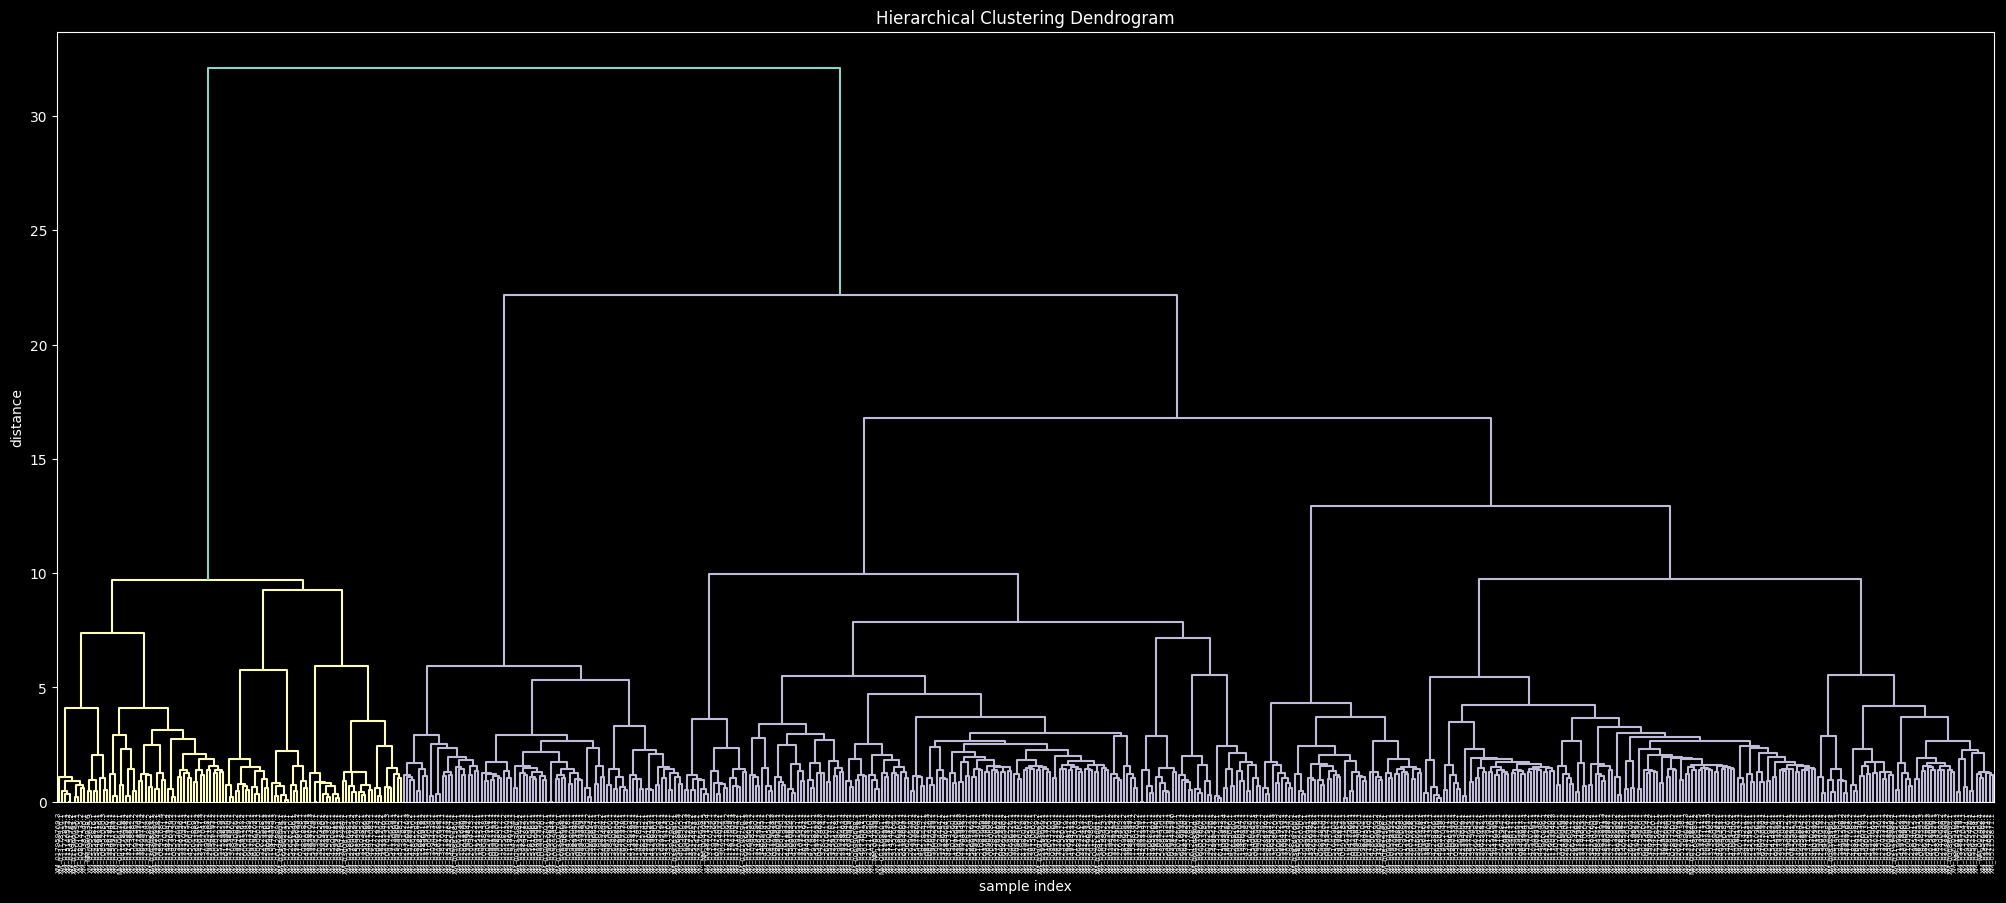

In [23]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np

# Z = linkage(adj_new, 'ward')
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# plt.xlabel('sample index')
# plt.ylabel('distance')
# dendrogram(Z, labels=labels, leaf_rotation=90)
# plt.show()

# #download the dendrogram
# plt.savefig("dendrogram.png")

#adjust the horizontal scale 
Z = linkage(adj_new, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(Z, labels=labels_new, leaf_rotation=90)
plt.show()

In [27]:
num_clusters = 2
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(Z, num_clusters, criterion='maxclust')
from collections import Counter
Counter(clusters)

Counter({2: 493, 1: 107})

In [25]:
#Kmeans 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(adj_new)
kmeans.labels_

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2,
       1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3,

In [26]:
Counter(kmeans.labels_)

Counter({1: 302, 3: 108, 0: 105, 2: 85})